In [1]:
library(data.table)
library(dplyr)
library(ggraph)
library(ggplot2)
library(igraph)
library(jsonlite)
library(patchwork)
library(progress)
library(purrr)
library(repr)
library(scales)
library(tibble)
library(tidygraph)
library(tidyr)
library(tidyverse)
library(torch)
library(viridis)
library(torch)
library(DT)

if (cuda_is_available()) {
  cat("GPU AVAILABLE\n")
} else {
  cat("GPU NOT available (torch installed without CUDA)\n")
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘purrr’


The following object is masked from ‘package:jsonlite’:

    flatten


The following objects are masked from ‘package:igraph’:

    compose, simplify


The following object is masked from ‘package:data.table’:

    transpose



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard



Attaching package: ‘tibble’


The following object

GPU AVAILABLE


In [2]:
hr_edges <- read.csv("/kaggle/input/influential-users-in-deezer-networks/deezer_clean_data/HR_edges.csv", header = FALSE, col.names = c("from", "to"))
hu_edges <- read.csv("/kaggle/input/influential-users-in-deezer-networks/deezer_clean_data/HU_edges.csv", header = FALSE, col.names = c("from", "to"))
ro_edges <- read.csv("/kaggle/input/influential-users-in-deezer-networks/deezer_clean_data/RO_edges.csv", header = FALSE, col.names = c("from", "to"))


hr_genres <- fromJSON("/kaggle/input/influential-users-in-deezer-networks/deezer_clean_data/HR_genres.json")
hu_genres <- fromJSON("/kaggle/input/influential-users-in-deezer-networks/deezer_clean_data/HU_genres.json")
ro_genres <- fromJSON("/kaggle/input/influential-users-in-deezer-networks/deezer_clean_data/RO_genres.json")

In [3]:
cat("=== Croatia (HR) ===\n")
cat("Nodes:", length(hr_genres), "  Edges:", nrow(hr_edges), "\n")
cat("Sample nodes & their genres:\n")
print(head(hr_genres, 10))

cat("\n=== Hungary (HU) ===\n")
cat("Nodes:", length(hu_genres), "  Edges:", nrow(hu_edges), "\n")
print(head(hu_genres, 10))

cat("\n=== Romania (RO) ===\n")
cat("Nodes:", length(ro_genres), "  Edges:", nrow(ro_edges), "\n")
print(head(ro_genres, 10))

=== Croatia (HR) ===
Nodes: 54573   Edges: 498203 
Sample nodes & their genres:
$`13357`
[1] "Pop"

$`11542`
[1] "Indie Rock"        "Indie Pop/Folk"    "International Pop"
[4] "Rap/Hip Hop"       "Pop"               "Rock"             
[7] "Indie Pop"         "Alternative"      

$`11543`
[1] "Dance" "Pop"   "Rock" 

$`11540`
[1] "International Pop" "Jazz"              "Pop"              

$`11541`
[1] "Rap/Hip Hop"

$`11546`
[1] "Dance"               "Pop"                 "Techno/House"       
[4] "International Pop"   "Electro"             "Singer & Songwriter"

$`11547`
[1] "Dance"       "Alternative" "Indie Rock"  "Pop"         "Rock"       

$`11544`
[1] "Films/Games"       "Dance"             "Rap/Hip Hop"      
[4] "Contemporary R&B"  "Pop"               "International Pop"
[7] "R&B"               "Rock"              "Film Scores"      

$`11545`
[1] "Pop"

$`11548`
[1] "Reggae"      "Rap/Hip Hop" "Pop"         "Rock"        "Alternative"
[6] "Folk"       


=== Hungary (HU) ==

In [4]:
datatable(head(hr_edges),options=list(scrollX=TRUE,scrollY="200px",pageLength=5,autoWidth=TRUE))

HTML widgets cannot be represented in plain text (need html)

In [5]:
datatable(head(hu_edges),options=list(scrollX=TRUE,scrollY="200px",pageLength=5,autoWidth=TRUE))

HTML widgets cannot be represented in plain text (need html)

In [6]:
datatable(head(ro_edges),options=list(scrollX=TRUE,scrollY="200px",pageLength=5,autoWidth=TRUE))

HTML widgets cannot be represented in plain text (need html)

In [7]:
deezer <- list()

countries <- c("HR", "HU", "RO")

for (code in countries) {
  cat("Loading", code, "...\n")
  
  # Edges
  edges_path <- paste0("/kaggle/input/influential-users-in-deezer-networks/deezer_clean_data/", code, "_edges.csv")
  edges <- read.csv(edges_path, header = FALSE, col.names = c("from", "to"))
  
  # Genres (JSON)
  genres_path <- paste0("/kaggle/input/influential-users-in-deezer-networks/deezer_clean_data/", code, "_genres.json")
  genres <- fromJSON(genres_path)
  
  # Store both in the list
  deezer[[code]] <- list(edges = edges, genres = genres)
}

cat("All 3 countries loaded successfully!\n")

Loading HR ...
Loading HU ...
Loading RO ...
All 3 countries loaded successfully!


In [8]:
library(progress)

cat("Building graphs for HR, HU, RO...\n\n")

# Beautiful tqdm-style progress bar
pb <- progress_bar$new(
  format = "  [:bar] :country | :current/:total (:percent) [:elapsed]",
  total = length(deezer),
  clear = FALSE,
  width = 80
)

graphs <- lapply(names(deezer), function(code) {
  pb$tick(tokens = list(country = code))  # Update bar
  
  edges  <- deezer[[code]]$edges
  genres <- deezer[[code]]$genres
  
  # All unique nodes
  all_nodes <- unique(c(edges$from, edges$to, names(genres)))
  
  # Fast vertex dataframe
  vertex_df <- data.frame(id = all_nodes, stringsAsFactors = FALSE)
  
  # Fast genre assignment
  vertex_df$genre_list  <- lapply(vertex_df$id, function(x) 
    if (x %in% names(genres)) genres[[x]] else character(0))
  vertex_df$genre_count <- lengths(vertex_df$genre_list)
  vertex_df$main_genre  <- sapply(vertex_df$genre_list, 
                                  function(x) if (length(x) > 0) x[1] else "Unknown")
  
  # Build graph
  g <- graph_from_data_frame(edges, directed = FALSE, vertices = vertex_df)
  
  # Add attributes
  V(g)$degree   <- degree(g)
  V(g)$country  <- code
  
  # Safe printing instead of pb$message()
  cat(sprintf("  Done %s → %d nodes, %d edges\n", 
              code, vcount(g), ecount(g)))
  
  g
}) %>% set_names(names(deezer))

cat("\nAll graphs created successfully! Ready for visualizations!\n")

Building graphs for HR, HU, RO...

  Done HR → 54575 nodes, 498203 edges
  Done HU → 47540 nodes, 222888 edges
  Done RO → 41775 nodes, 125827 edges

All graphs created successfully! Ready for visualizations!


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


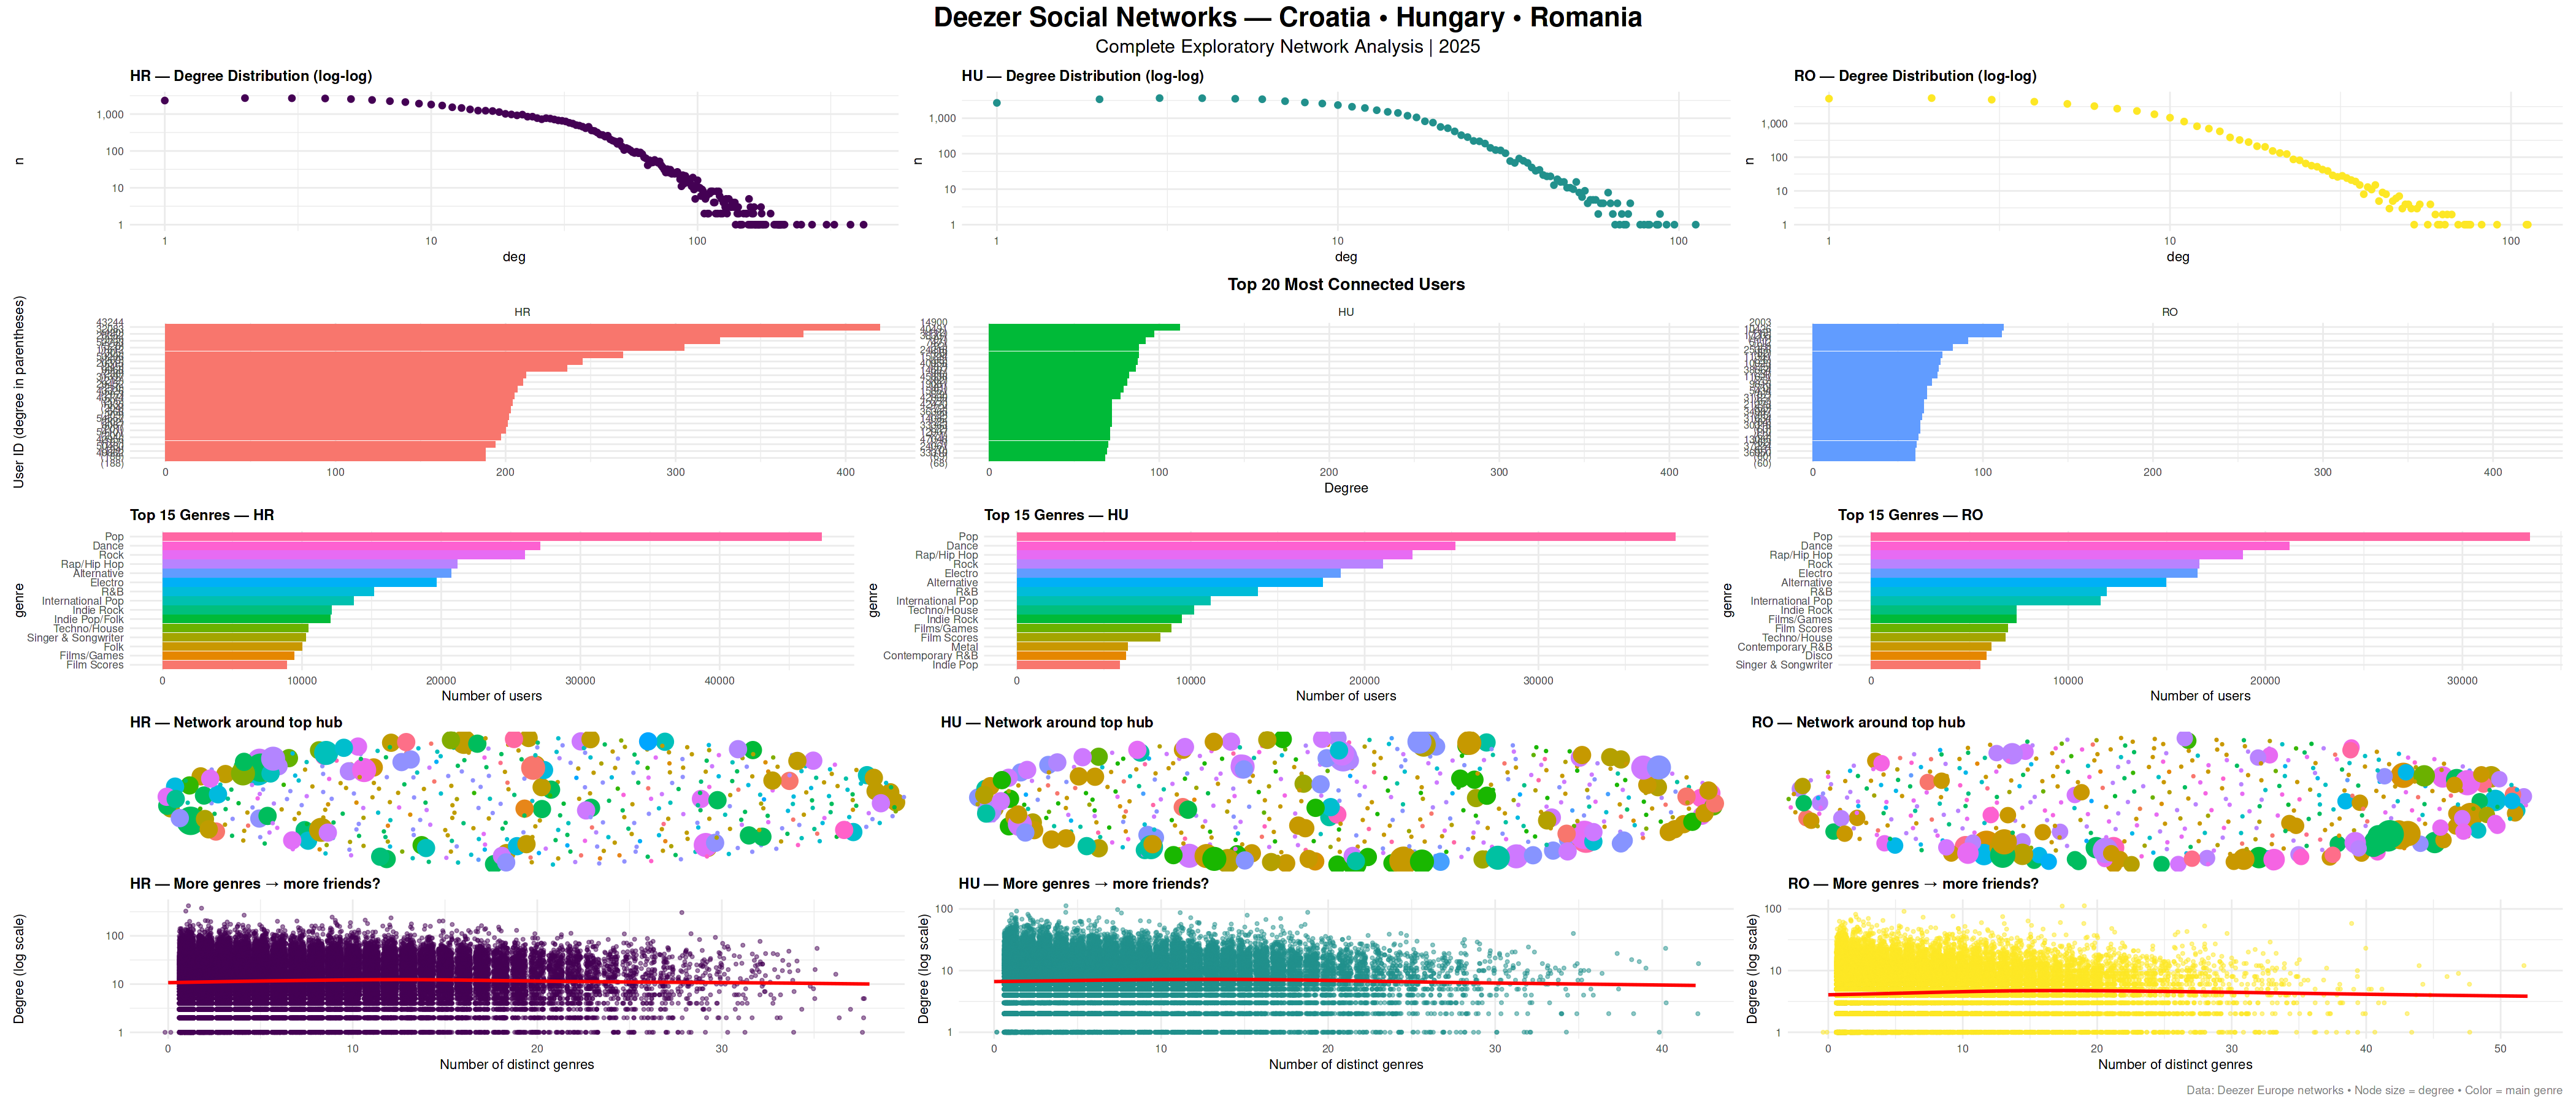

In [9]:
theme_set(theme_minimal(base_size = 13))

p_deg <- lapply(names(graphs), function(code) {
  d <- degree(graphs[[code]])
  tibble(deg = d) %>%
    count(deg) %>%
    ggplot(aes(deg, n)) +
    geom_point(size = 2.5, color = viridis(3)[which(names(graphs) == code)]) +
    scale_x_log10(labels = comma) +
    scale_y_log10(labels = comma) +
    labs(title = paste(code, "— Degree Distribution (log-log)")) +
    theme(plot.title = element_text(size = 14, face = "bold"))
}) %>% wrap_plots(ncol = 3)

top20 <- lapply(names(graphs), function(code) {
  g <- graphs[[code]]
  top <- names(sort(degree(g), decreasing = TRUE)[1:20])
  tibble(user = top, degree = degree(g)[top], country = code)
}) %>% bind_rows() %>%
  mutate(label = paste0(user, "\n(", degree, ")"))

p_top <- ggplot(top20, aes(x = reorder(label, degree), y = degree, fill = country)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  facet_wrap(~ country, scales = "free_y") +
  labs(title = "Top 20 Most Connected Users",
       x = "User ID (degree in parentheses)", y = "Degree") +
  theme_minimal(base_size = 13) +
  theme(plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
        axis.text.y = element_text(size = 9.5))

p_genre <- lapply(names(graphs), function(code) {
  all_g <- unlist(deezer[[code]]$genres)
  as.data.frame(table(all_g)) %>%
    setNames(c("genre", "Freq")) %>%
    arrange(desc(Freq)) %>%
    slice_max(Freq, n = 15) %>%
    mutate(genre = fct_reorder(genre, Freq)) %>%
    ggplot(aes(genre, Freq, fill = genre)) +
    geom_col(show.legend = FALSE) +
    coord_flip() +
    labs(title = paste("Top 15 Genres —", code), y = "Number of users") +
    theme(plot.title = element_text(size = 14, face = "bold"))
}) %>% wrap_plots(ncol = 3)

set.seed(123)
p_net <- lapply(names(graphs), function(code) {
  g <- graphs[[code]]
  hub <- which.max(degree(g))
  neigh <- neighborhood(g, order = 3, nodes = hub)[[1]]
  nodes_sample <- sample(neigh, min(500, length(neigh)))
  g_sub <- induced_subgraph(g, nodes_sample)
  
  ggraph(g_sub, layout = "fr") +
    geom_edge_link(aes(alpha = 0.3), colour = "gray70", show.legend = FALSE) +
    geom_node_point(aes(size = degree(g_sub), colour = V(g_sub)$main_genre)) +
    scale_size_continuous(range = c(1, 12)) +
    labs(title = paste(code, "— Network around top hub")) +
    theme_void() +
    theme(legend.position = "none",
          plot.title = element_text(size = 14, face = "bold"))
}) %>% wrap_plots(ncol = 3)

p_scatter <- lapply(names(graphs), function(code) {
  g <- graphs[[code]]
  tibble(deg = degree(g), n_genres = V(g)$genre_count) %>%
    ggplot(aes(n_genres, deg)) +
    geom_jitter(alpha = 0.5, size = 1.2,
                colour = viridis(3)[which(names(graphs) == code)]) +
    geom_smooth(colour = "red", se = FALSE, size = 1.2) +
    scale_y_log10(labels = comma) +
    labs(title = paste(code, "— More genres → more friends?"),
         x = "Number of distinct genres", y = "Degree (log scale)") +
    theme(plot.title = element_text(size = 14, face = "bold"))
}) %>% wrap_plots(ncol = 3)

final_combined <- (p_deg / p_top / p_genre / p_net / p_scatter) +
  plot_annotation(
    title = "Deezer Social Networks — Croatia • Hungary • Romania",
    subtitle = "Complete Exploratory Network Analysis | 2025",
    caption = "Data: Deezer Europe networks • Node size = degree • Color = main genre",
    theme = theme(
      plot.title = element_text(size = 26, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 18, hjust = 0.5),
      plot.caption = element_text(size = 11, color = "gray50")
    )
  )

options(repr.plot.width = 35, repr.plot.height = 15)
final_combined

In [10]:
# Cell 1: Create influence labels based on degree (top 5% = influential)
set.seed(42)

graphs_labeled <- lapply(names(graphs), function(code) {
  g <- graphs[[code]]
  
  deg <- degree(g)
  threshold <- quantile(deg, 0.85)  # Top 5%
  
  V(g)$influential <- as.numeric(deg >= threshold)
  V(g)$degree_log <- log1p(deg)  # For regression alternative
  
  cat(code, ": threshold =", round(threshold), 
      "| Influential users =", sum(V(g)$influential), 
      "| (", round(mean(V(g)$influential)*100, 2), "% )\n")
  
  g
}) %>% set_names(names(graphs))

HR : threshold = 34 | Influential users = 8343 | ( 15.29 % )
HU : threshold = 16 | Influential users = 7774 | ( 16.35 % )
RO : threshold = 10 | Influential users = 7256 | ( 17.37 % )


In [11]:
# Cell 2: Build global genre vocabulary + one-hot encode
all_genres <- unlist(lapply(deezer, function(x) unlist(x$genres)))
genre_vocab <- sort(unique(all_genres))
n_genres <- length(genre_vocab)
cat("Total unique genres across 3 countries:", n_genres, "\n")

# Map genre to index
genre_to_idx <- setNames(1:n_genres, genre_vocab)

# Function to make one-hot feature vector
make_features <- function(genre_list) {
  vec <- numeric(n_genres)
  if (length(genre_list) > 0) {
    idx <- genre_to_idx[genre_list]
    idx <- idx[!is.na(idx)]
    if (length(idx) > 0) vec[idx] <- 1
  }
  vec
}

# Add features to all graphs
for (code in names(graphs_labeled)) {
  g <- graphs_labeled[[code]]
  feature_list <- lapply(V(g)$genre_list, make_features)
  feature_matrix <- do.call(rbind, feature_list)
  
  # Also add degree as a feature (optional but powerful!)
  feature_matrix <- cbind(feature_matrix, degree(g) / max(degree(g)))
  colnames(feature_matrix)[ncol(feature_matrix)] <- "norm_degree"
  
  V(g)$features <- lapply(1:vcount(g), function(i) feature_matrix[i, ])
  graphs_labeled[[code]] <- g
}
cat("Node features created (one-hot genres + normalized degree)\n")

Total unique genres across 3 countries: 88 
Node features created (one-hot genres + normalized degree)


In [12]:

igraph_to_torch_fixed <- function(g, label_type = "binary") {
  edgelist <- as_edgelist(g, names = FALSE) - 1L
  n_nodes <- vcount(g)
  edgelist <- edgelist[edgelist[,1] >= 0 & edgelist[,2] >= 0 & edgelist[,1] < n_nodes & edgelist[,2] < n_nodes, , drop = FALSE]
  if (nrow(edgelist) == 0) {
    edge_index <- torch_tensor(matrix(integer(), nrow = 2, ncol = 0), dtype = torch_long())
  } else {
    edge_index <- torch_tensor(t(edgelist), dtype = torch_long())
    edge_index <- torch_cat(list(edge_index, edge_index[c(2,1), ]), dim = 2)
    mat <- as.matrix(edge_index$t())
    mat <- mat[mat[,1] != mat[,2], , drop = FALSE]
    mat <- unique(mat)
    mat <- mat[order(mat[,1], mat[,2]), ]
    mat <- mat + 1L
    edge_index <- torch_tensor(t(mat), dtype = torch_long())
  }
  x <- do.call(rbind, V(g)$features)
  x <- torch_tensor(x, dtype = torch_float())
  if (label_type == "binary") {
    y <- torch_tensor(as.integer(V(g)$influential), dtype = torch_long())
  } else {
    y <- torch_tensor(V(g)$degree_log, dtype = torch_float())$unsqueeze(2)
  }
  list(x = x, edge_index = edge_index, y = y, num_nodes = n_nodes)
}


In [13]:
g_hr <- graphs_labeled$HR
data <- igraph_to_torch_fixed(g_hr, label_type = "binary")

data$y <- data$y + 1L

n <- data$num_nodes
idx <- torch_randperm(n) + 1L

train_ratio <- 0.7
val_ratio   <- 0.15

train_idx <- idx[1:as.integer(n * 0.7)]
val_idx   <- idx[(as.integer(n * 0.7) + 1):as.integer(n * 0.85)]
test_idx  <- idx[(as.integer(n * 0.85) + 1):n]

data$train_mask <- torch_zeros(n, dtype = torch_bool())
data$val_mask   <- torch_zeros(n, dtype = torch_bool())
data$test_mask  <- torch_zeros(n, dtype = torch_bool())

data$train_mask[train_idx] <- TRUE
data$val_mask[val_idx]     <- TRUE
data$test_mask[test_idx]   <- TRUE

cat(
  "Data prepared | Train:", sum(data$train_mask$to(dtype = torch_int()))$item(),
  "| Val:", sum(data$val_mask$to(dtype = torch_int()))$item(),
  "| Test:", sum(data$test_mask$to(dtype = torch_int()))$item(), "\n"
)


Data prepared | Train: 38202 | Val: 8186 | Test: 8187 


In [14]:
graphsage_layer <- nn_module(
  "GraphSAGE",
  initialize = function(in_features, out_features) {
    self$lin <- nn_linear(in_features, out_features)
  },
  forward = function(x, edge_index) {
    src <- edge_index[1, ] + 1L
    dst <- edge_index[2, ] + 1L
    
    agg <- torch_zeros_like(x)
    agg <- agg$index_add(1, dst, x[src, ])
    
    deg <- torch_zeros(x$size(1))$index_add(1, dst, torch_ones_like(dst, dtype = torch_float()))
    deg <- deg$clamp(min = 1)$unsqueeze(2)
    
    out <- agg / deg
    out <- out + x
    self$lin(out)$relu()
  }
)


In [15]:
mean_agg <- function(x, edge_index, num_nodes) {
  src <- edge_index[1, ]
  dst <- edge_index[2, ]
  
  out <- torch_zeros(num_nodes, x$size(2), dtype = x$dtype, device = x$device)
  out$index_add_(1, dst, x[src, ])
  
  deg <- torch_zeros(num_nodes, 1, dtype = x$dtype, device = x$device)
  deg$index_add_(1, dst, torch_ones(src$size(1), 1, dtype = x$dtype, device = x$device))
  
  out / deg$clamp(min = 1)
}

simple_layer <- nn_module(
  initialize = function(in_dim, out_dim) {
    self$lin  <- nn_linear(in_dim, out_dim)
    self$norm <- nn_layer_norm(out_dim)
    self$res_proj <- if (in_dim != out_dim) nn_linear(in_dim, out_dim, bias = FALSE) else NULL
  },
  forward = function(x, edge_index, num_nodes) {
    h <- mean_agg(x, edge_index, num_nodes)
    h <- self$lin(h)
    h <- nnf_gelu(h)
    h <- self$norm(h)
    
    if (!is.null(self$res_proj)) x <- self$res_proj(x)
    h + x
  }
)

model <- nn_module(
  initialize = function(input_dim) {
    self$proj  <- nn_linear(input_dim, 512)
    self$norm0 <- nn_layer_norm(512)
    
    self$l1 <- simple_layer(512, 512)
    self$l2 <- simple_layer(512, 512)
    self$l3 <- simple_layer(512, 256)
    self$l4 <- simple_layer(256, 256)
    self$l5 <- simple_layer(256, 128)
    
    self$clf <- nn_sequential(
      nn_linear(128, 256), nn_gelu(), nn_dropout(0.5),
      nn_linear(256, 128), nn_gelu(), nn_dropout(0.5),
      nn_linear(128, 2)
    )
  },
  forward = function(x, edge_index) {
    h <- self$proj(x)
    h <- nnf_gelu(self$norm0(h))
    
    n_nodes <- x$size(1)
    h <- self$l1(h, edge_index, n_nodes)
    h <- self$l2(h, edge_index, n_nodes)
    h <- self$l3(h, edge_index, n_nodes)
    h <- self$l4(h, edge_index, n_nodes)
    h <- self$l5(h, edge_index, n_nodes)
    
    self$clf(h)
  }
)

In [16]:
net <- model(data$x$size(2))

device <- if (cuda_is_available()) "cuda" else "cpu"
net$to(device = device)
data$x <- data$x$to(device = device)
data$edge_index <- data$edge_index$to(device = device)

data$y <- data$y$to(device = device)
data$train_mask <- data$train_mask$to(device = device)
data$val_mask   <- data$val_mask$to(device = device)
data$test_mask  <- data$test_mask$to(device = device)

out <- net(data$x, data$edge_index)
cat("SUCCESS! Everything on GPU. Output shape:", out$size(), "\n")

SUCCESS! Everything on GPU. Output shape: 54575 2 


In [17]:
model_summary <- function(model) {
  total_params <- 0
  
  cat("====================================================================\n")
  cat("                MODEL SUMMARY – torch for R\n")
  cat("====================================================================\n\n")
  
  safe_numel <- function(p) {
    if (is.null(p)) return(0)
    if (inherits(p, "torch_tensor")) return(p$numel())
    return(0)
  }
  
  walk_modules <- function(mod, prefix = "") {
    for (name in names(mod$modules)) {
      submod <- mod$modules[[name]]
      
      n_params <- 0
      for (p in submod$parameters) {
        n_params <- n_params + safe_numel(p)
      }
      total_params <<- total_params + n_params
      
      full_name <- if (prefix == "") name else paste0(prefix, ".", name)
      
      if (inherits(submod, "nn_linear")) {
        in_f  <- submod$in_features
        out_f <- submod$out_features
        bias  <- if (is.null(submod$bias)) 0 else out_f
        cat(sprintf("%-48s %-22s %12s params\n",
                    full_name,
                    paste0("[n_nodes, ", out_f, "]"),
                    format(in_f * out_f + bias, big.mark = ",")))
        
      } else if (inherits(submod, "nn_layer_norm")) {
        sz <- submod$normalized_shape[[1]]
        cat(sprintf("%-48s %-22s %12s params   (γ + β)\n",
                    full_name,
                    paste0("[n_nodes, ", sz, "]"),
                    format(2 * sz, big.mark = ",")))
        
      } else if (inherits(submod, "nn_sequential")) {
        cat(sprintf("%-48s (classifier head)\n", full_name))
        
      } else if (inherits(submod, "nn_module") && length(submod$modules) > 0) {
        cat(sprintf("%-48s <%s>\n", full_name, class(submod)[1]))
      }
      
      if (length(submod$modules) > 0) {
        new_prefix <- if (prefix == "") name else paste0(prefix, ".", name)
        walk_modules(submod, new_prefix)
      }
    }
  }
  
  walk_modules(model)
  
  cat("\n====================================================================\n")
  cat(sprintf("Total trainable parameters : %s\n", format(total_params, big.mark = ",")))
  cat("Output shape                : [num_nodes, 2]\n")
  cat("Message passing             : Mean aggregation over neighbors\n")
  cat("Activation                  : GELU\n")
  cat("Normalization               : LayerNorm\n")
  cat("Residual connections        : Yes (with projection when needed)\n")
  cat("====================================================================\n")
}

model_summary(net)

                MODEL SUMMARY – torch for R

proj                                             [n_nodes, 512]               46,080 params
norm0                                            [n_nodes, 512]                1,024 params   (γ + β)
l1                                               <nn_module>
l1.lin                                           [n_nodes, 512]              262,656 params
l1.norm                                          [n_nodes, 512]                1,024 params   (γ + β)
l1.lin                                           [n_nodes, 512]              262,656 params
l1.norm                                          [n_nodes, 512]                1,024 params   (γ + β)
l2                                               <nn_module>
l2.lin                                           [n_nodes, 512]              262,656 params
l2.norm                                          [n_nodes, 512]                1,024 params   (γ + β)
l2.lin                                           [n_nodes

In [18]:
# Edge index (1-based for torch R) - KEEP THIS
edge_list_1based <- as_edgelist(g_hr, names = FALSE)
src <- edge_list_1based[,1] - 1L
dst <- edge_list_1based[,2] - 1L
edges <- rbind(cbind(src, dst), cbind(dst, src))
edges <- edges[edges[,1] != edges[,2], , drop = FALSE]
edges <- edges[!duplicated(paste(pmax(edges[,1], edges[,2]), pmin(edges[,1], edges[,2]))), ]
edges <- edges[order(edges[,1], edges[,2]), ]
edges_1based <- edges + 1L
data$edge_index <- torch_tensor(t(edges_1based), dtype = torch_long(), device = device)

cat("EDGE_INDEX:\n")
cat("Shape:", data$edge_index$size(), "\n")
cat("Min index:", data$edge_index$min()$item(), " Max index:", data$edge_index$max()$item(), "\n")
cat("Num nodes:", data$num_nodes, "\n\n")

# ADD CLASS WEIGHTS - THIS IS THE CRITICAL FIX FOR YOUR 5% ACCURACY
n_class1 <- sum(as_array(data$y[data$train_mask]) == 1)  # Non-influential
n_class2 <- sum(as_array(data$y[data$train_mask]) == 2)  # Influential

cat("Class distribution:\n")
cat("  Non-influential:", n_class1, "\n")
cat("  Influential:", n_class2, "\n")
cat("  Ratio:", round(n_class1/n_class2, 2), ":1\n\n")

# Weight for minority class (THIS IS THE KEY FIX!)
weights <- torch_tensor(c(1.0, n_class1/n_class2), dtype = torch_float(), device = device)
cat("Using class weights:", as_array(weights), "\n\n")

# === OPTIMIZER & LOSS ===
optimizer <- optim_adam(net$parameters, lr = 1e-5)
criterion <- nn_cross_entropy_loss(weight = weights)  

EDGE_INDEX:
Shape: 2 498203 
Min index: 1  Max index: 54575 
Num nodes: 54575 

Class distribution:
  Non-influential: 32286 
  Influential: 5916 
  Ratio: 5.46 :1

Using class weights: 1 5.457404 



In [19]:
# === TRAINING LOOP (100% working) ===
history <- data.frame(
  epoch = integer(),
  train_loss = numeric(),
  train_acc = numeric(),
  val_loss = numeric(),
  val_acc = numeric()
)

for (epoch in 1:500) {
  
  ### TRAINING ###
  net$train()
  optimizer$zero_grad()
  
  out <- net(data$x, data$edge_index)
  
  loss_train <- criterion(out[data$train_mask, ], data$y[data$train_mask])
  loss_train$backward()
  optimizer$step()
  
  # Train accuracy
  pred_train <- out[data$train_mask, ]$argmax(dim = 2) + 1L
  acc_train <- (pred_train == data$y[data$train_mask])$to(dtype = torch_float())$mean()$item()
  
  ### VALIDATION ###
  net$eval()
  with_no_grad({
    out_val <- net(data$x, data$edge_index)
    loss_val <- criterion(out_val[data$val_mask, ], data$y[data$val_mask])
    
    pred_val <- out_val[data$val_mask, ]$argmax(dim = 2) + 1L
    acc_val <- (pred_val == data$y[data$val_mask])$to(dtype = torch_float())$mean()$item()
  })
  
  ### LOGGING ###
  history <- rbind(history, data.frame(
    epoch = epoch,
    train_loss = loss_train$item(),
    train_acc = acc_train,
    val_loss = loss_val$item(),
    val_acc = acc_val
  ))
  
  if (epoch %% 100 == 0 || epoch == 1) {
    cat(sprintf("Epoch %3d | Train Loss: %.4f Acc: %.4f | Val Loss: %.4f Acc: %.4f\n",
                epoch, loss_train$item(), acc_train, loss_val$item(), acc_val))
  }
}

cat("Training finished!\n")

Epoch   1 | Train Loss: 0.7088 Acc: 0.1238 | Val Loss: 0.6938 Acc: 0.1438
Epoch 100 | Train Loss: 0.5851 Acc: 0.0383 | Val Loss: 0.5786 Acc: 0.0325
Epoch 200 | Train Loss: 0.4939 Acc: 0.0296 | Val Loss: 0.4758 Acc: 0.0276
Epoch 300 | Train Loss: 0.4288 Acc: 0.0276 | Val Loss: 0.4158 Acc: 0.0227
Epoch 400 | Train Loss: 0.3883 Acc: 0.0226 | Val Loss: 0.3811 Acc: 0.0237
Epoch 500 | Train Loss: 0.3570 Acc: 0.0214 | Val Loss: 0.3606 Acc: 0.0230
Training finished!


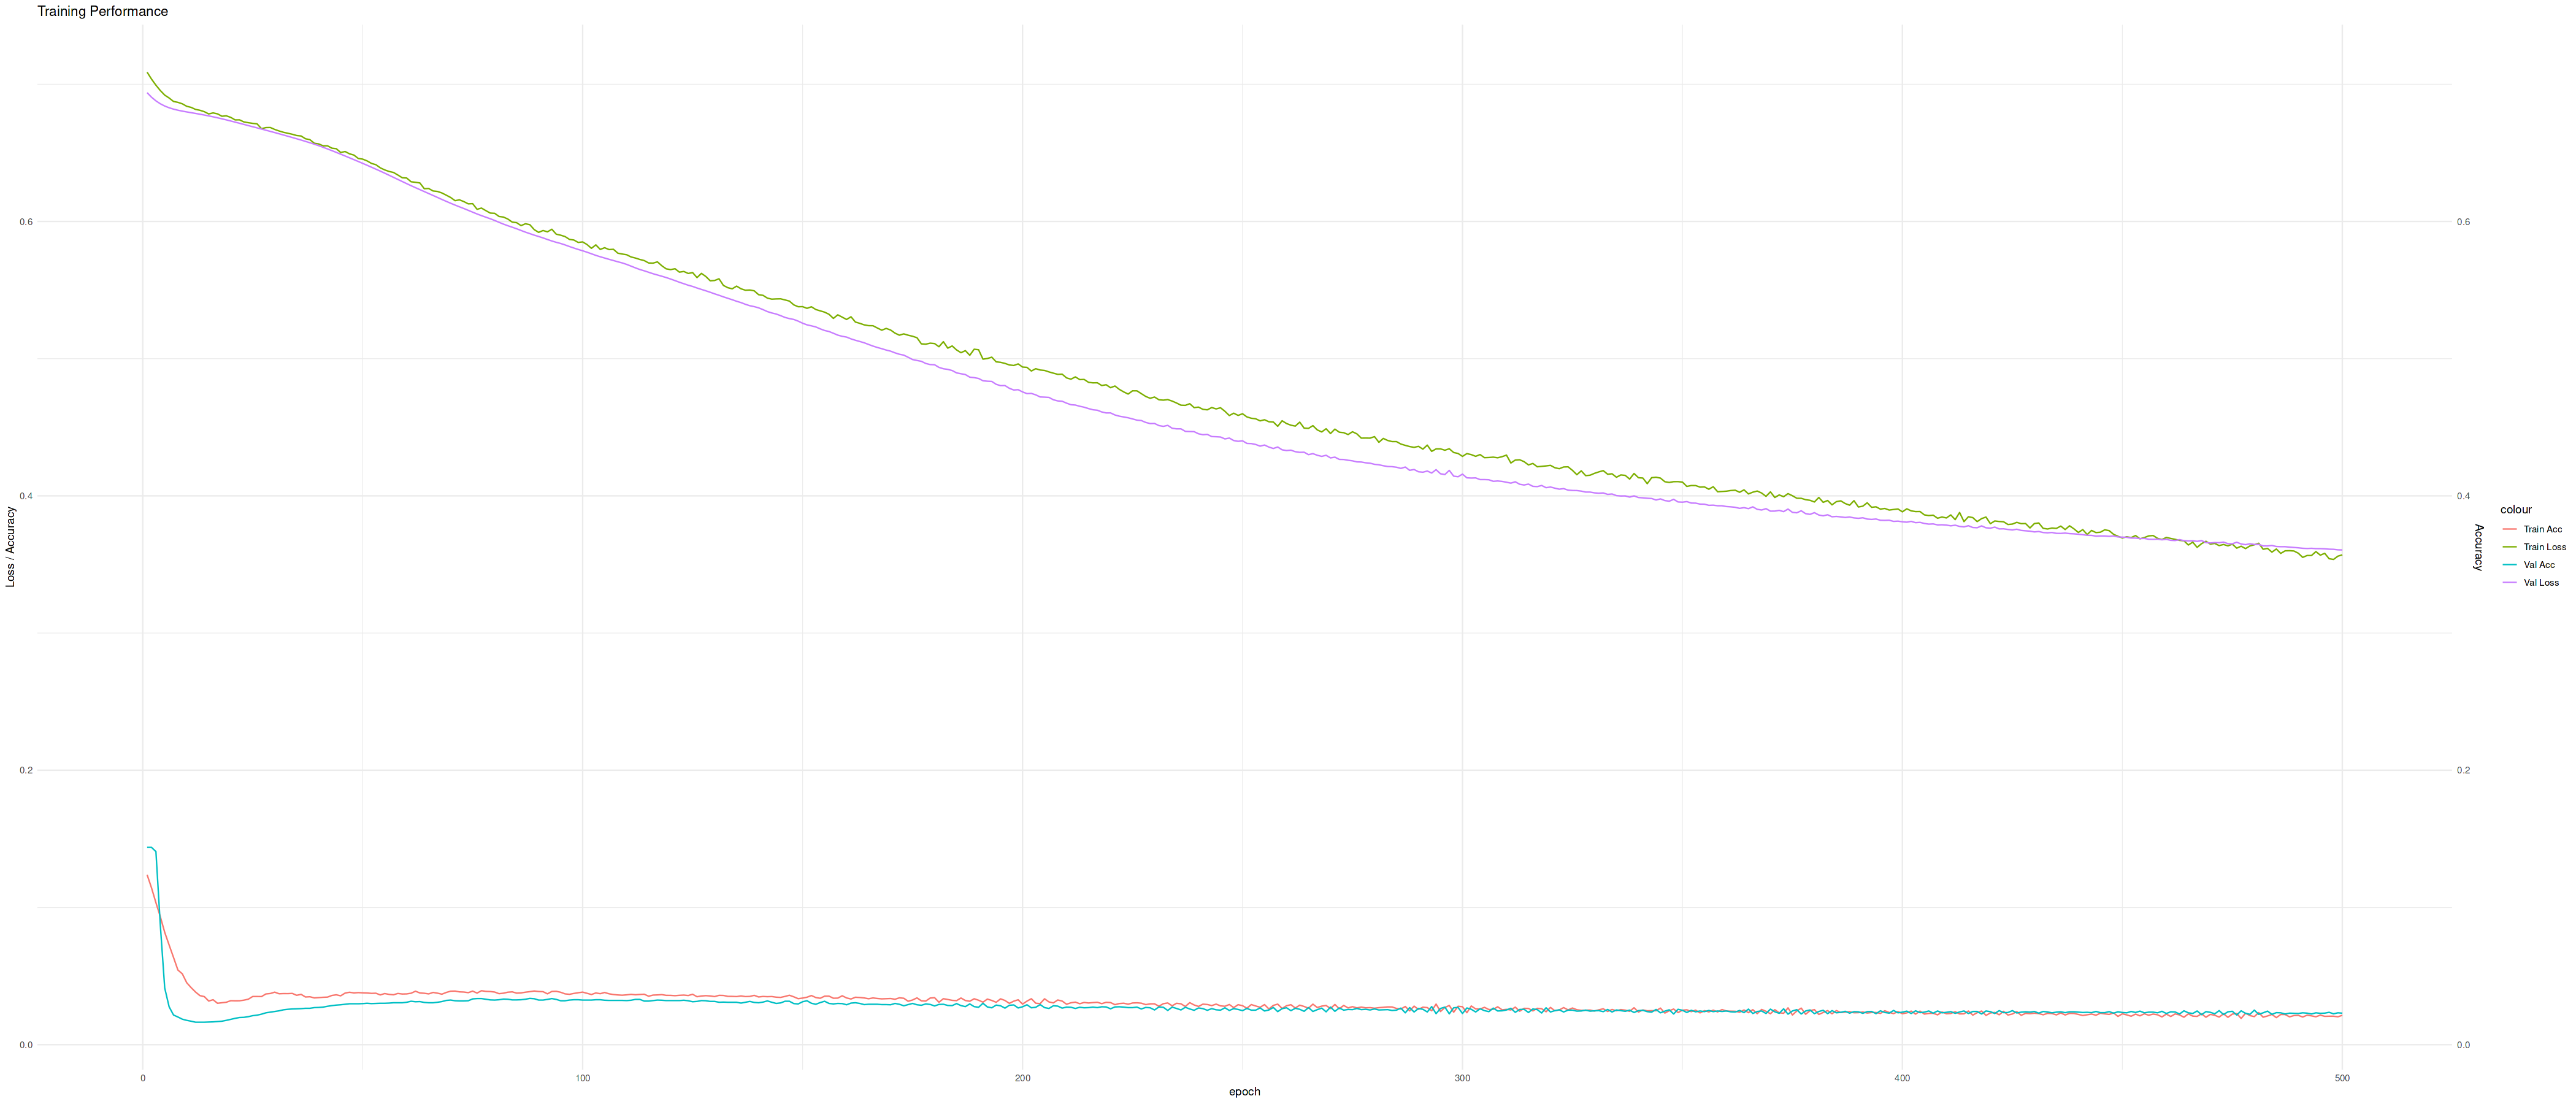

In [20]:

ggplot(history, aes(x = epoch)) +
  geom_line(aes(y = train_loss, color = "Train Loss")) +
  geom_line(aes(y = val_loss, color = "Val Loss")) +
  geom_line(aes(y = train_acc, color = "Train Acc")) +
  geom_line(aes(y = val_acc, color = "Val Acc")) +
  scale_y_continuous(sec.axis = dup_axis(name = "Accuracy")) +
  labs(title = "Training Performance", y = "Loss / Accuracy") +
  theme_minimal()

options(repr.plot.width = 35, repr.plot.height = 15)

In [21]:
net$train(FALSE)  # Set to evaluation mode

with_no_grad({
  logits <<- net(data$x, data$edge_index)
  prob   <<- logits$softmax(dim = 2)
  pred   <<- prob$argmax(dim = 2) + 1L
})

# Test accuracy
correct <- (pred[data$test_mask] == data$y[data$test_mask])$
           to(dtype = torch_bool())$
           sum()$
           item()
total   <- sum(as_array(data$test_mask))
acc <- correct / total * 100
cat("Test Accuracy:", round(acc, 2), "%\n")

# Top-20 predicted influential users
test_idx <- which(as_array(data$test_mask))
prob_matrix <- as_array(prob)
influential_prob <- prob_matrix[test_idx, 2]
top20 <- order(influential_prob, decreasing = TRUE)[1:20]

# Get vertex names
vertex_names <- igraph::V(g_hr)$name

# Build data frame
result <- data.frame(
  rank       = 1:20,
  user       = vertex_names[test_idx[top20]],
  prob       = round(influential_prob[top20], 4),
  true_label = ifelse(as_array(data$y[test_idx[top20]]) == 2, "Influential", "Non-influential"),
  predicted  = ifelse(as_array(pred[test_idx[top20]]) == 2, "Influential", "Non-influential")
)

print(result, row.names = FALSE)

Test Accuracy: 2.49 %
 rank  user   prob      true_label       predicted
    1 17264 0.9862     Influential Non-influential
    2 16490 0.9790     Influential Non-influential
    3 41011 0.9784     Influential Non-influential
    4 31397 0.9779     Influential Non-influential
    5 34163 0.9771     Influential Non-influential
    6 16393 0.9771     Influential Non-influential
    7 49336 0.9770     Influential Non-influential
    8  9434 0.9769     Influential Non-influential
    9 47046 0.9762     Influential Non-influential
   10 14037 0.9752     Influential Non-influential
   11 49204 0.9751     Influential Non-influential
   12 34997 0.9744     Influential Non-influential
   13   648 0.9743     Influential Non-influential
   14 45142 0.9741     Influential Non-influential
   15 40360 0.9729     Influential Non-influential
   16 18997 0.9727     Influential Non-influential
   17 52539 0.9722     Influential Non-influential
   18 17755 0.9720     Influential Non-influential
   19 224

In [22]:
net$train(FALSE)  # Set to evaluation mode
with_no_grad({
  out <- net(data$x, data$edge_index)
  prob <- out$softmax(2)
  prob_cpu <- as_array(prob$cpu())   # Convert tensor to R array
  final_emb <- prob_cpu[, 2]         # Probability of being influential
  pred_label <- ifelse(final_emb > 0.5, "Influential", "Regular")
  pred_score <- final_emb
})

V(g_hr)$gnn_score <- pred_score
V(g_hr)$gnn_label <- pred_label
V(g_hr)$true_influential <- ifelse(V(g_hr)$influential == 1, "True Influencer", "Not Influencer")

cat("GNN predictions added to graph!\n")
cat("Top 10 predicted influencers:\n")

top10_pred <- order(V(g_hr)$gnn_score, decreasing = TRUE)[1:10]
print(data.frame(
  user = V(g_hr)$name[top10_pred],
  degree = degree(g_hr)[top10_pred],
  gnn_score = round(V(g_hr)$gnn_score[top10_pred], 4),
  true = V(g_hr)$influential[top10_pred]
))

GNN predictions added to graph!
Top 10 predicted influencers:
       user degree gnn_score true
25352 25352    326    0.9874    1
17264 17264     83    0.9862    1
32083 32083    375    0.9857    1
11612 11612    269    0.9849    1
25536 25536     92    0.9846    1
9968   9968    212    0.9846    1
29452 29452    207    0.9844    1
6991   6991     45    0.9837    1
39869 39869     73    0.9832    1
43244 43244    420    0.9832    1


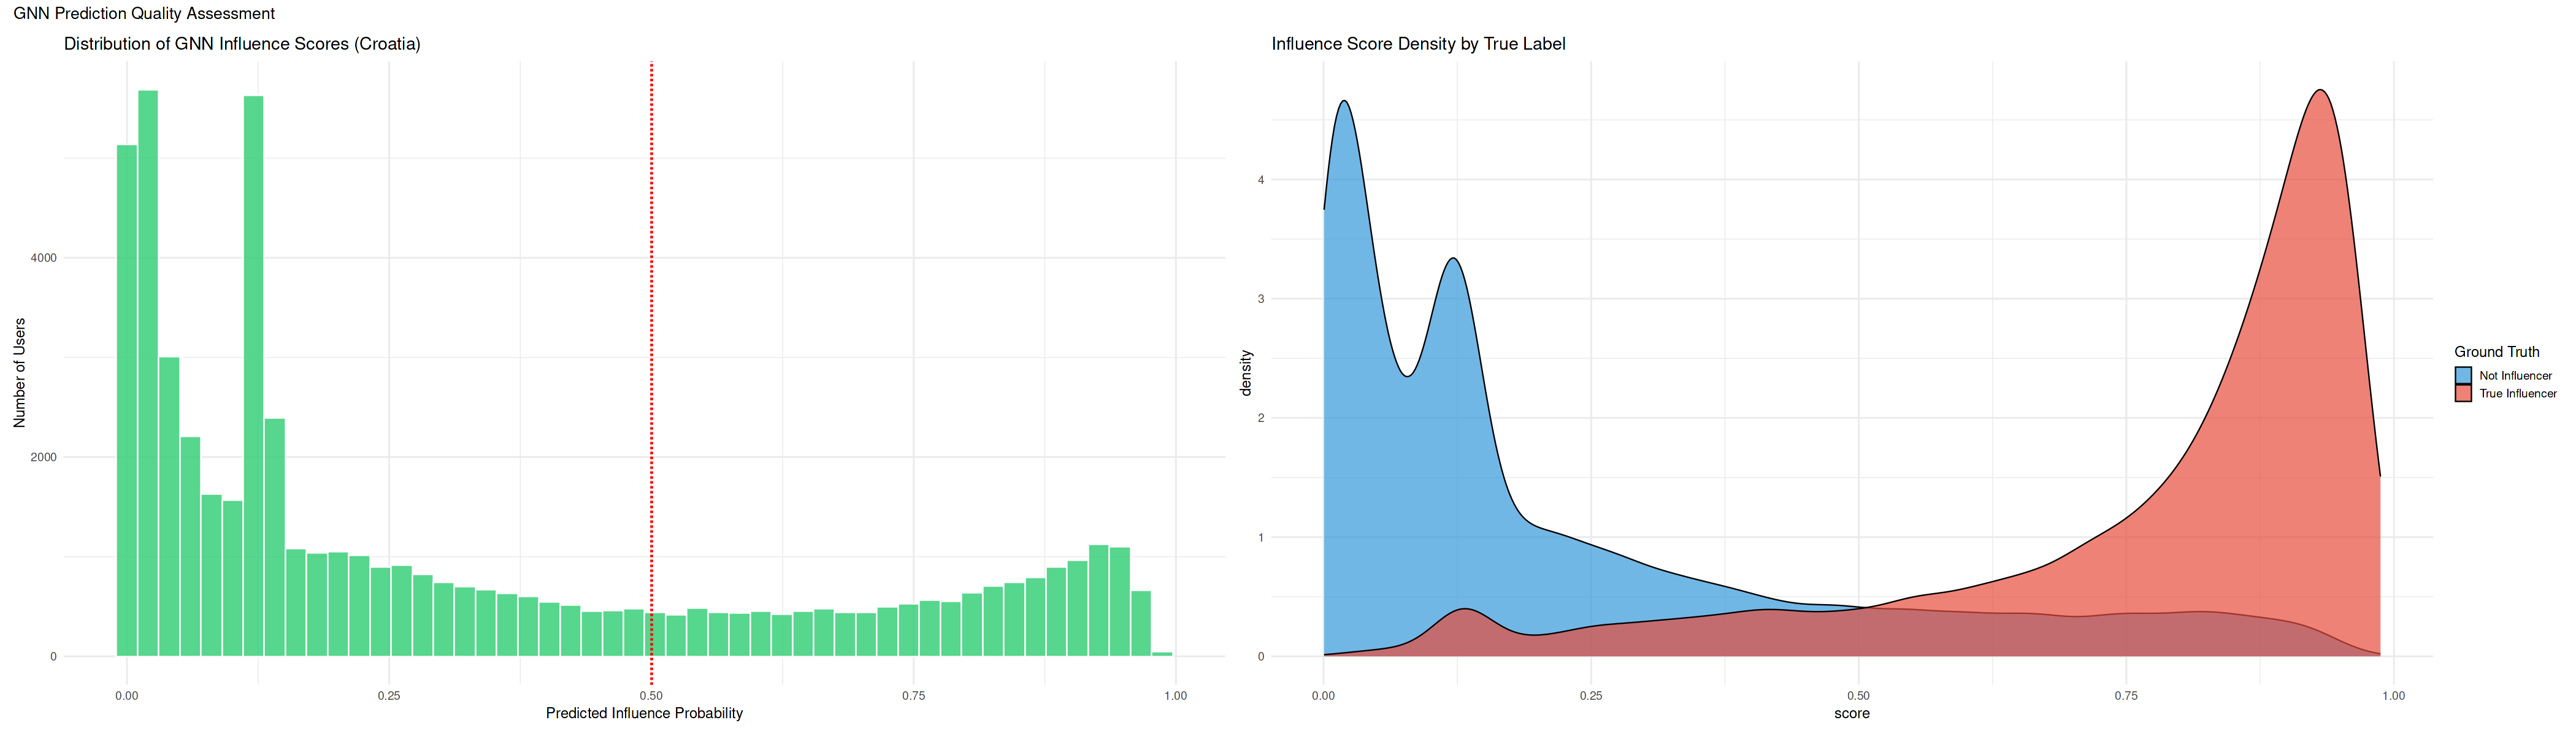

In [23]:
p1 <- ggplot(data.frame(score = V(g_hr)$gnn_score), aes(score)) +
  geom_histogram(bins = 50, fill = "#2ecc71", alpha = 0.8, color = "white") +
  geom_vline(xintercept = 0.5, linetype = "dashed", color = "red", size = 1) +
  labs(title = "Distribution of GNN Influence Scores (Croatia)", x = "Predicted Influence Probability", y = "Number of Users") +
  theme_minimal(base_size = 14)

p2 <- ggplot(data.frame(score = V(g_hr)$gnn_score, true = V(g_hr)$true_influential), 
             aes(score, fill = true)) +
  geom_density(alpha = 0.7) +
  scale_fill_manual(values = c("True Influencer" = "#e74c3c", "Not Influencer" = "#3498db")) +
  labs(title = "Influence Score Density by True Label", fill = "Ground Truth") +
  theme_minimal(base_size = 14)

options(repr.plot.width = 35, repr.plot.height = 10)

(p1 | p2) + plot_annotation(title = "GNN Prediction Quality Assessment")

options(repr.plot.width = 35, repr.plot.height = 15)


=== TEST SET METRICS ===
Accuracy: 0.02491755 
Influential Recall: 0.1632 
Influential Precision: 0.03408521 
Total Influential in Test: 1250 
Predicted Influential: 5985 


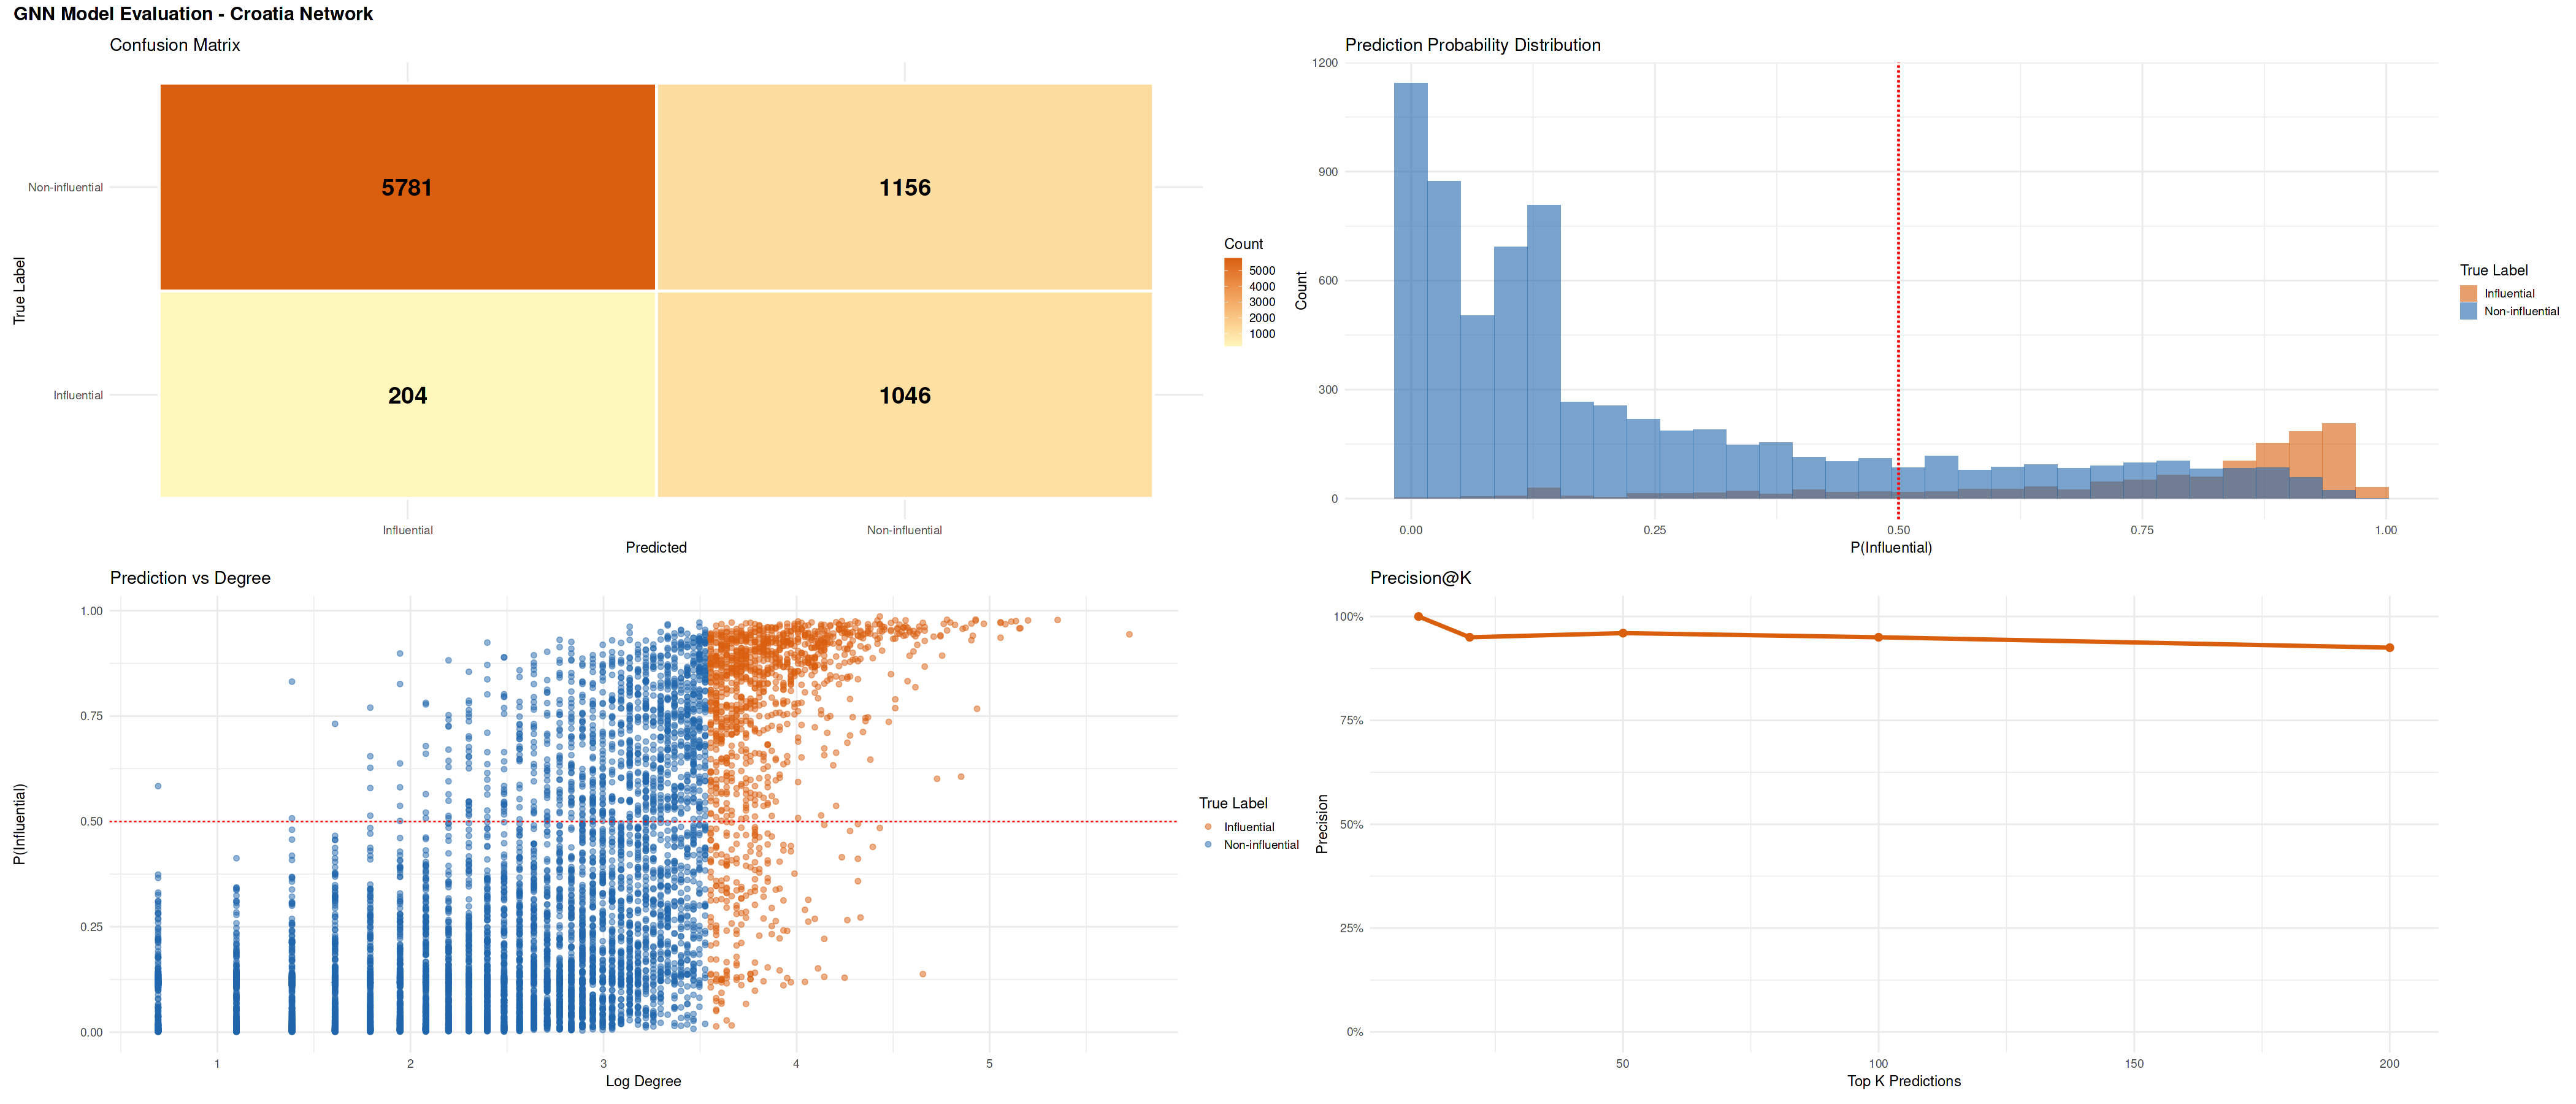

In [24]:
net$train(FALSE)

# Get predictions on test set
with_no_grad({
  out <- net(data$x, data$edge_index)
  prob <- out$softmax(2)
  prob_cpu <- as_array(prob$cpu())
  pred <- out$argmax(2) + 1L
})

# Extract test set data
test_idx <- which(as_array(data$test_mask))
y_true <- as_array(data$y[data$test_mask])
y_pred <- as_array(pred[data$test_mask])
prob_influential <- prob_cpu[test_idx, 2]

# Create evaluation dataframe
eval_df <- data.frame(
  true_label = factor(ifelse(y_true == 2, "Influential", "Non-influential")),
  pred_label = factor(ifelse(y_pred == 2, "Influential", "Non-influential")),
  prob_influential = prob_influential,
  degree = degree(g_hr)[test_idx]
)

# 1. Confusion Matrix Heatmap
confusion <- table(eval_df$true_label, eval_df$pred_label)
confusion_df <- as.data.frame(confusion)
colnames(confusion_df) <- c("True", "Predicted", "Count")

p1 <- ggplot(confusion_df, aes(Predicted, True, fill = Count)) +
  geom_tile(color = "white", size = 1) +
  geom_text(aes(label = Count), size = 8, fontface = "bold") +
  scale_fill_gradient(low = "#fff7bc", high = "#d95f0e") +
  labs(title = "Confusion Matrix", x = "Predicted", y = "True Label") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "right")

# 2. ROC-like: Probability Distribution by True Class
p2 <- ggplot(eval_df, aes(x = prob_influential, fill = true_label)) +
  geom_histogram(alpha = 0.6, position = "identity", bins = 30) +
  geom_vline(xintercept = 0.5, linetype = "dashed", color = "red", size = 1) +
  scale_fill_manual(values = c("Influential" = "#d95f0e", "Non-influential" = "#2166ac")) +
  labs(title = "Prediction Probability Distribution",
       x = "P(Influential)", y = "Count", fill = "True Label") +
  theme_minimal(base_size = 14)

# 3. Calibration: Predicted Prob vs Degree
p3 <- ggplot(eval_df, aes(x = log1p(degree), y = prob_influential, color = true_label)) +
  geom_point(alpha = 0.5, size = 2) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
  scale_color_manual(values = c("Influential" = "#d95f0e", "Non-influential" = "#2166ac")) +
  labs(title = "Prediction vs Degree",
       x = "Log Degree", y = "P(Influential)", color = "True Label") +
  theme_minimal(base_size = 14)

# 4. Top-K Precision
top_k <- c(10, 20, 50, 100, 200)
precision_at_k <- sapply(top_k, function(k) {
  top_k_idx <- order(prob_influential, decreasing = TRUE)[1:min(k, length(prob_influential))]
  sum(y_true[top_k_idx] == 2) / length(top_k_idx)
})

precision_df <- data.frame(k = top_k, precision = precision_at_k)

p4 <- ggplot(precision_df, aes(x = k, y = precision)) +
  geom_line(color = "#d95f0e", size = 1.5) +
  geom_point(color = "#d95f0e", size = 3) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  labs(title = "Precision@K", x = "Top K Predictions", y = "Precision") +
  theme_minimal(base_size = 14)

# Combine all plots
(p1 | p2) / (p3 | p4) +
  plot_annotation(title = "GNN Model Evaluation - Croatia Network",
                  theme = theme(plot.title = element_text(size = 18, face = "bold")))

options(repr.plot.width = 35, repr.plot.height = 15)

# Print metrics
cat("\n=== TEST SET METRICS ===\n")
cat("Accuracy:", mean(y_pred == y_true), "\n")
cat("Influential Recall:", sum(y_pred[y_true == 2] == 2) / sum(y_true == 2), "\n")
cat("Influential Precision:", sum(y_true[y_pred == 2] == 2) / sum(y_pred == 2), "\n")
cat("Total Influential in Test:", sum(y_true == 2), "\n")
cat("Predicted Influential:", sum(y_pred == 2), "\n")

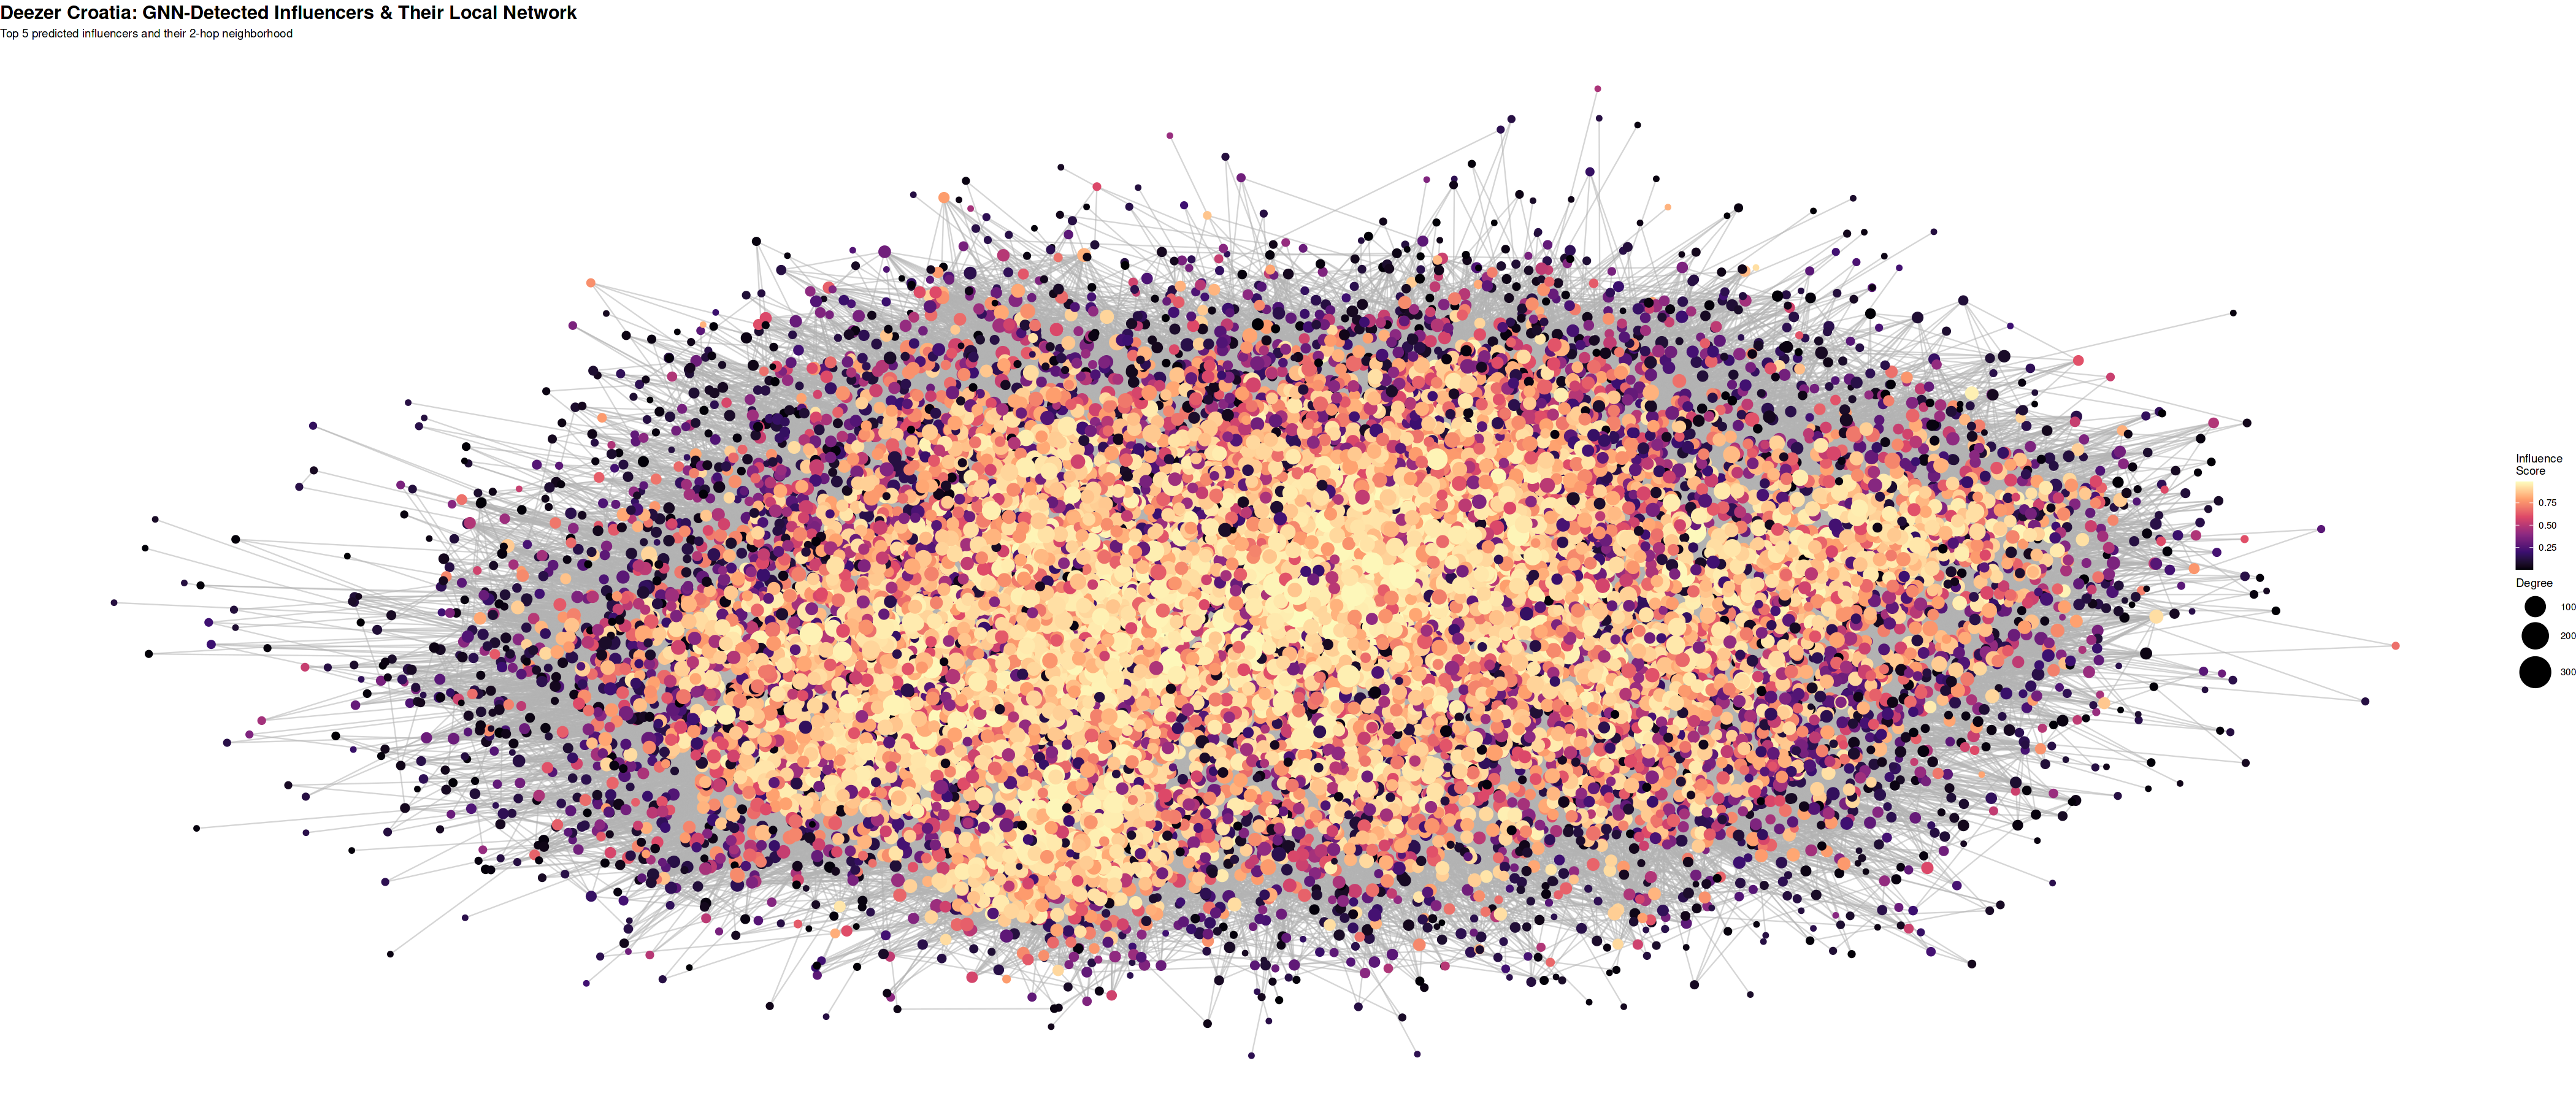

In [25]:
# Cell 12: Sample subgraph around top 5 predicted influencers
set.seed(123)
top_influencers <- order(V(g_hr)$gnn_score, decreasing = TRUE)[1:5]
neighbors <- unique(unlist(neighborhood(g_hr, order = 2, nodes = top_influencers)))

g_sub <- induced_subgraph(g_hr, neighbors)

ggraph(g_sub, layout = "fr") +
  geom_edge_link(aes(alpha = 0.2), color = "gray70", show.legend = FALSE) +
  geom_node_point(aes(color = gnn_score, size = degree(g_sub))) +
  scale_color_viridis_c(option = "magma", name = "Influence\nScore") +
  scale_size_continuous(range = c(2, 15), name = "Degree") +
  labs(title = "Deezer Croatia: GNN-Detected Influencers & Their Local Network",
       subtitle = "Top 5 predicted influencers and their 2-hop neighborhood") +
  theme_void() +
  theme(legend.position = "right", plot.title = element_text(size = 18, face = "bold"))

options(repr.plot.width = 35, repr.plot.height = 15)

In [26]:
torch_save(net$state_dict(), "gnn_influencer_model_state.pt")

save_data <- list(
  x          = as.array(data$x$cpu()),
  edge_index = as.array(data$edge_index$cpu()),
  y          = as.array(data$y$cpu()),
  test_mask  = as.array(data$test_mask$cpu()),
  num_nodes  = data$num_nodes,
  influential = V(g_hr)$influential,
  name        = V(g_hr)$name
)

save(save_data, g_hr, file = "gnn_influencer_app_data.RData", compress = "xz")